In [1]:
#IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#MOUNT DRIVE
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
#LOAD DATA
us_accident_data = pd.read_csv('/content/drive/My Drive/IA-TP1/Accidente.csv')

In [ ]:
us_accident_data.head(10)

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day
5,A-6,MapQuest,201.0,3,2016-02-08 07:44:26,2016-02-08 08:14:26,40.100590,-82.925194,NaN,NaN,0.01,Accident on I-270 Outerbelt Northbound near Ex...,NaN,Westerville Rd,R,Westerville,Franklin,OH,43081,US,US/Eastern,KCMH,2016-02-08 07:51:00,37.9,35.5,97.0,29.63,7.0,SSW,3.5,0.03,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
6,A-7,MapQuest,201.0,2,2016-02-08 07:59:35,2016-02-08 08:29:35,39.758274,-84.230507,NaN,NaN,0.00,Accident on Oakridge Dr at Woodward Ave. Expec...,376.0,N Woodward Ave,R,Dayton,Montgomery,OH,45417-2476,US,US/Eastern,KDAY,2016-02-08 07:56:00,34.0,31.0,100.0,29.66,7.0,WSW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
7,A-8,MapQuest,201.0,3,2016-02-08 07:59:58,2016-02-08 08:29:58,39.770382,-84.194901,NaN,NaN,0.01,Accident on I-75 Southbound at Exit 54B Grand ...,NaN,N Main St,R,Dayton,Montgomery,OH,45405,US,US/Eastern,KDAY,2016-02-08 07:56:00,34.0,31.0,100.0,29.66,7.0,WSW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
8,A-9,MapQuest,201.0,2,2016-02-08 08:00:40,2016-02-08 08:30:40,39.778061,-84.172005,NaN,NaN,0.00,Accident on Notre Dame Ave at Warner Ave. Expe...,99.0,Notre Dame Ave,L,Dayton,Montgomery,OH,45404-1923,US,US/Eastern,KFFO,2016-02-08 07:58:00,33.3,NaN,99.0,29.67,5.0,SW,1.2,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
9,A-10,MapQuest,201.0,3,2016-02-08 08:10:04,20

#### Analyzing NaNs values

In [ ]:
us_accident_data.isnull().sum().sort_values()

ID                             0
Crossing                       0
Give_Way                       0
Junction                       0
No_Exit                        0
Railway                        0
Roundabout                     0
Station                        0
Stop                           0
Country                        0
Traffic_Calming                0
State                          0
County                         0
Bump                           0
Side                           0
Traffic_Signal                 0
Distance(mi)                   0
Turning_Loop                   0
Start_Lng                      0
Start_Lat                      0
End_Time                       0
Start_Time                     0
Severity                       0
Source                         0
Street                         0
Amenity                        0
Description                    1
City                          83
Sunrise_Sunset                93
Civil_Twilight                93
Astronomic

### Model
We want a predictor system that doesn't depend on variables that can be obtained after the accident when it comes to predicting severity, such as _distance_, _end_time_, _duration_, _end_lat_, _end_lng_. That is why we will not take them into account when developing our models.

#### Analyzing ID variable

In [ ]:
#As we notice, these are unique values, so we don't believe that this variable adds value to the model.
us_accident_data.ID.nunique()==len(us_accident_data)

True

#### Analyzing _Source_

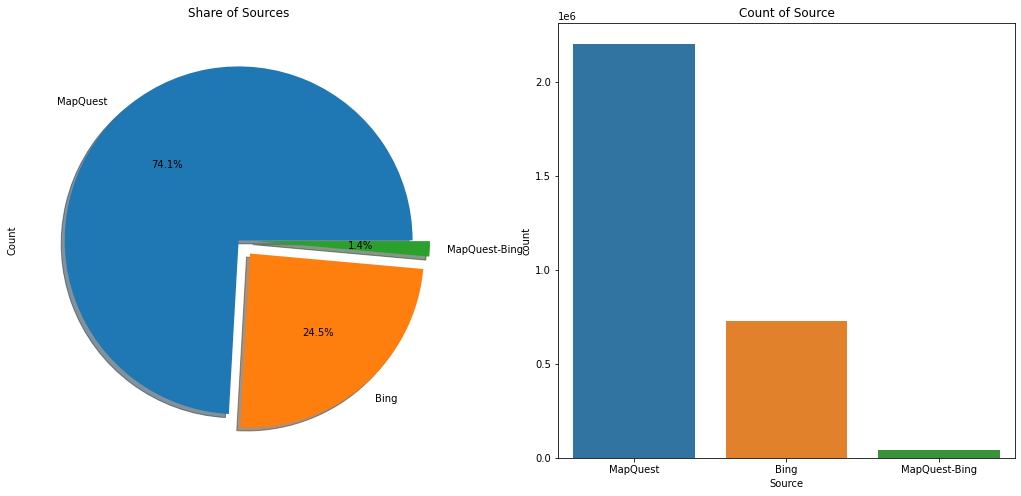

In [ ]:
#The data provided is from 3 different sources and it doesn't seems to be relevant to pedict the severity of the accident.
f,ax=plt.subplots(1,2,figsize=(18,8))
us_accident_data['Source'].value_counts().plot.pie(explode=[0,0.1,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Share of Sources')
ax[0].set_ylabel('Count')
sns.countplot('Source',data=us_accident_data,ax=ax[1],order=us_accident_data['Source'].value_counts().index)
ax[1].set_title('Count of Source')
plt.show()

#### Analyzing _Start_Time_ and _End_Time_

We analyze the time difference between _start_time_ and _end_time_. Taking into consideration that a variable that determines the end of the accident is not relevant to our model since accidents occur in a fraction of a second and, that's why we decided not to consider those two variables.

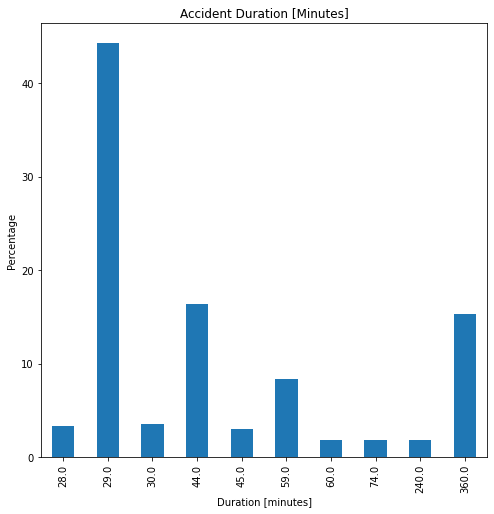

In [ ]:
start_time = pd.to_datetime(us_accident_data.Start_Time, format='%Y-%m-%d %H:%M:%S')
end_time = pd.to_datetime(us_accident_data.End_Time, format='%Y-%m-%d %H:%M:%S')
duration = (end_time-start_time)
top10 = duration.astype('timedelta64[m]').value_counts().nlargest(10).sort_index()
(100*top10/top10.sum()).plot.bar(figsize=(8,8))
plt.title('Accident Duration [Minutes]')
plt.xlabel('Duration [minutes]')
plt.ylabel('Percentage');

#### Analyzing _Start_Lat_ and _End_Lat_ 

Notice that 75% of _end_lat_ is  missing. Besides we don't considerer this attribute relevant to predict accident severity so we will only use _start_lat_. As mentioned before, end_lat is only possible with the presence of an expert in the place of the accident,so along this notebook we will not take into consideratin any of the attributes with this characteristic.

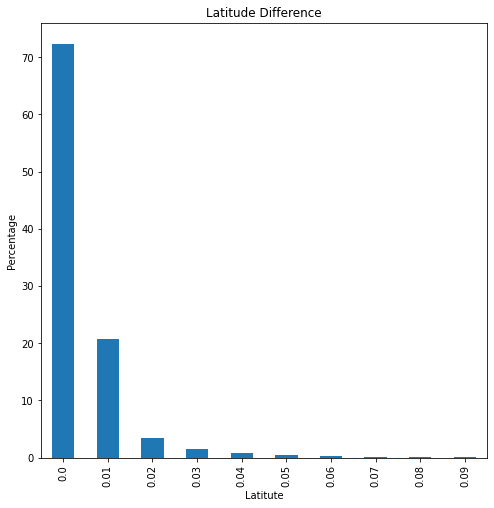

In [ ]:
diff_lat = abs(round(us_accident_data[us_accident_data.End_Lat.notna()].End_Lat-us_accident_data[us_accident_data.End_Lat.notna()].Start_Lat, 2))
top10 = diff_lat.value_counts().nlargest(10).sort_index()
(100*top10/top10.sum()).plot.bar(figsize=(8,8))
plt.title('Latitude Difference')
plt.xlabel('Latitute')
plt.ylabel('Percentage');

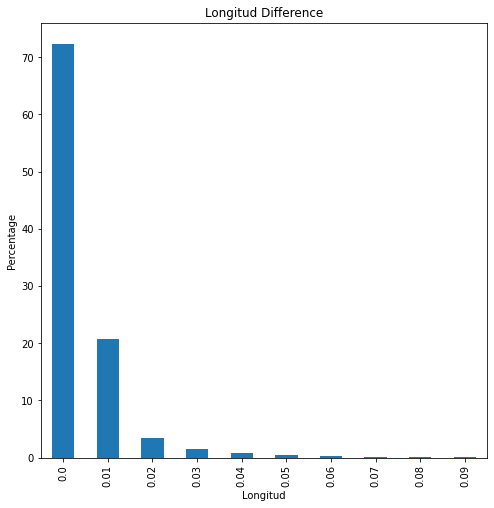

In [ ]:
#The same that end_lat applies to end_lon
diff_lng = abs(round(us_accident_data[us_accident_data.End_Lng.notna()].End_Lng-us_accident_data[us_accident_data.End_Lng.notna()].Start_Lng, 2))
top10 = diff_lat.value_counts().nlargest(10).sort_index()
(100*top10/top10.sum()).plot.bar(figsize=(8,8))
plt.title('Longitud Difference')
plt.xlabel('Longitud')
plt.ylabel('Percentage');

For the aforementioned reasons, we will not be using _end_lon_

#### Analyzing _Distance_

Again _distance_ is an attribute that we will get only if the expert attends to the place of the accident, so that's why we are not going to use it in our model so that our predictor could work independently.

Text(0, 0.5, 'Percentage')

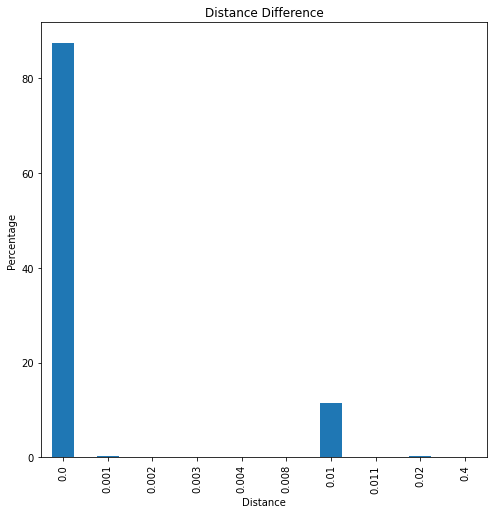

In [4]:
top10 = round(us_accident_data['Distance(mi)'], 3).value_counts().nlargest(10).sort_index()
(100*top10/top10.sum()).plot.bar(figsize=(8,8))
plt.title('Distance Difference')
plt.xlabel('Distance')
plt.ylabel('Percentage')

Text(0, 0.5, 'Distances')

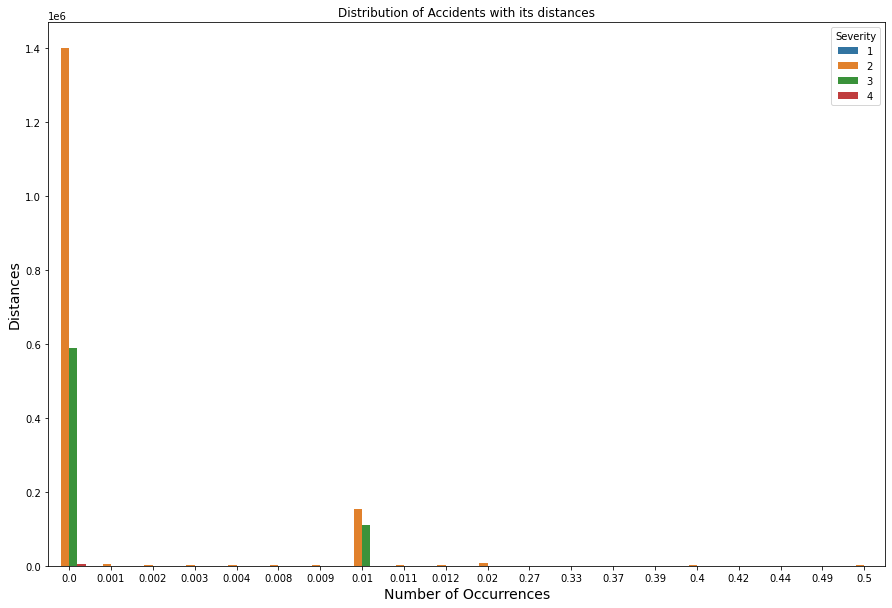

In [ ]:
distance_accident = set(us_accident_data['Distance(mi)'].round(3).value_counts().nlargest(20).keys())
cases = [val in distance_accident for val in us_accident_data['Distance(mi)'].round(3)]
plt.figure(figsize=(15,10))
sns.countplot(x='Distance(mi)', hue="Severity", data=us_accident_data[cases].round(decimals=3), order = sorted(distance_accident))
plt.title('Distribution of Accidents with its distances')
plt.xlabel('Number of Occurrences', fontsize=14)
plt.ylabel('Distances', fontsize=14)

#### Analyzing our target value, _Severity_
As we can see, we have a considerable imbalance, between the classes that we have, that is why it would be ideal, to get more data that allows us in some way, to balance the dataset

Text(0, 0.5, 'Percentage')

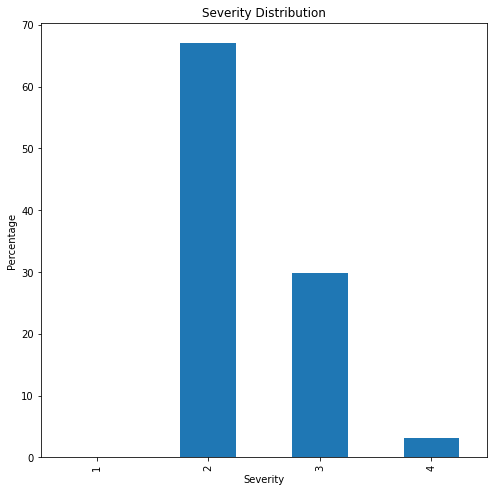

In [ ]:
top10 = us_accident_data['Severity'].value_counts().sort_index()
(100*top10/top10.sum()).plot.bar(figsize=(8,8))
plt.title('Severity Distribution')
plt.xlabel('Severity')
plt.ylabel('Percentage')

In [ ]:
Severity_distribution  = us_accident_data.Severity.value_counts().reset_index()
Severity_distribution.columns=['Severity','Cases']
Severity_distribution

,Severity,Cases
0,2,1993410
1,3,887620
2,4,92337
3,1,968


#### Analyzing _Number_

There is 65% of the values missing. In addition to this, we believe it's enough with _start_lat_ and _start_lon_, so it wont' be used in our model.

#### Analyzing _Description_
In this project we won't be applying NLP or TF-IDF to better analyze a semantic analysis of description, so we proceed to discard the column since it will generate more noise to our predictor.

#### Analyzing _Street_
We consider that the _lat_ and _lng_ position is sufficient, that is why we proceed to discard such a column when taking it into account in our analysis.

#### Analyzing _Side_
This column has two possible values Right and Left.

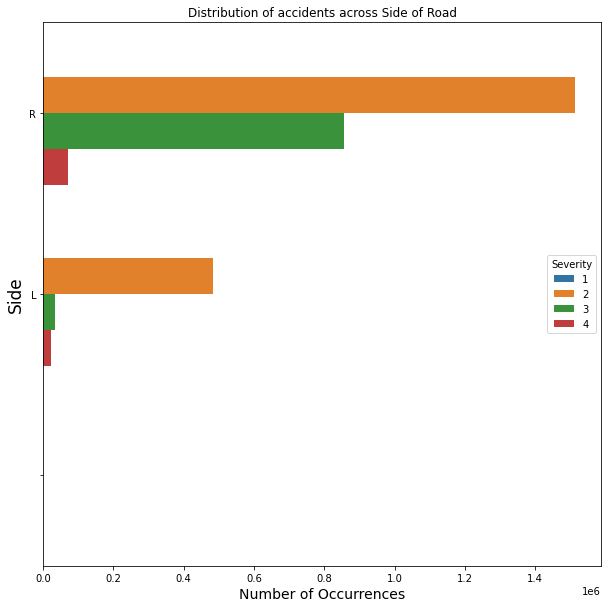

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y="Side", hue="Severity", data=us_accident_data,order = us_accident_data.Side.value_counts().index)
plt.title('Distribution of accidents across Side of Road')
plt.xlabel('Number of Occurrences', fontsize=14)
plt.ylabel('Side', fontsize=17)
plt.show()

#### Analyzing _Ciy_

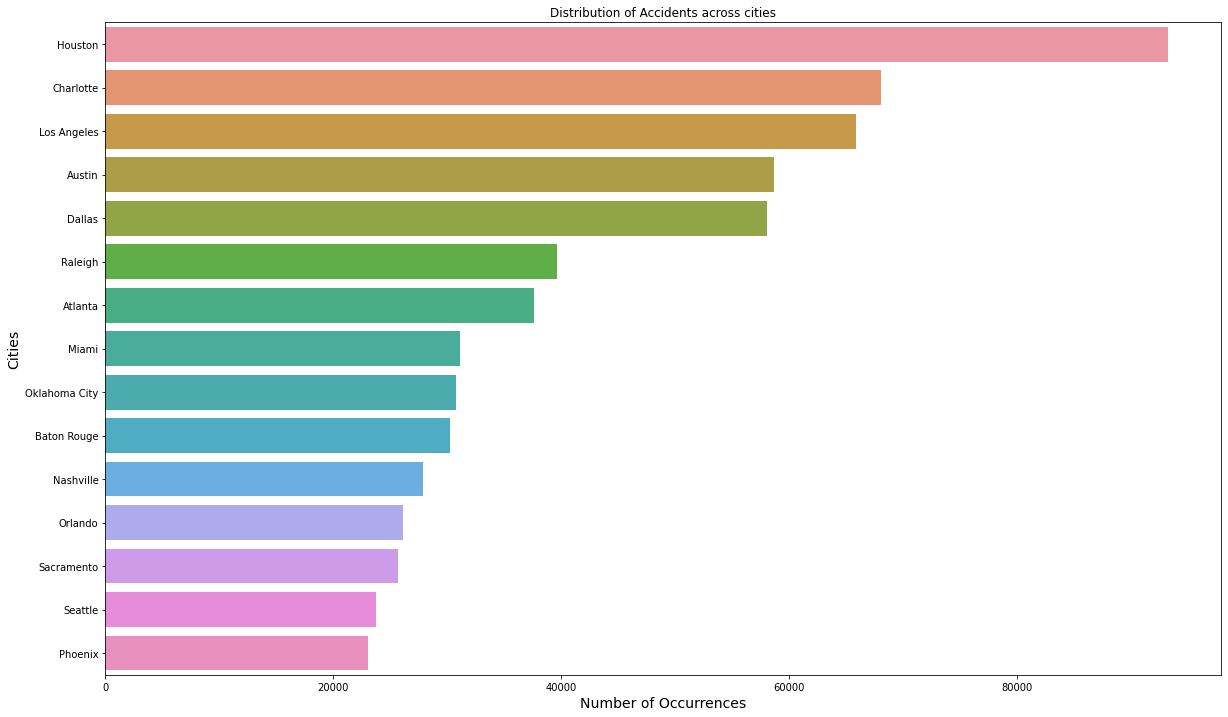

In [ ]:

plt.figure(figsize=(20,12))
sns.countplot(y='City', data = us_accident_data, order = us_accident_data.City.value_counts().index[:15])
plt.title('Distribution of Accidents across cities')
plt.xlabel('Number of Occurrences', fontsize=14)
plt.ylabel('Cities', fontsize=14)
plt.show()

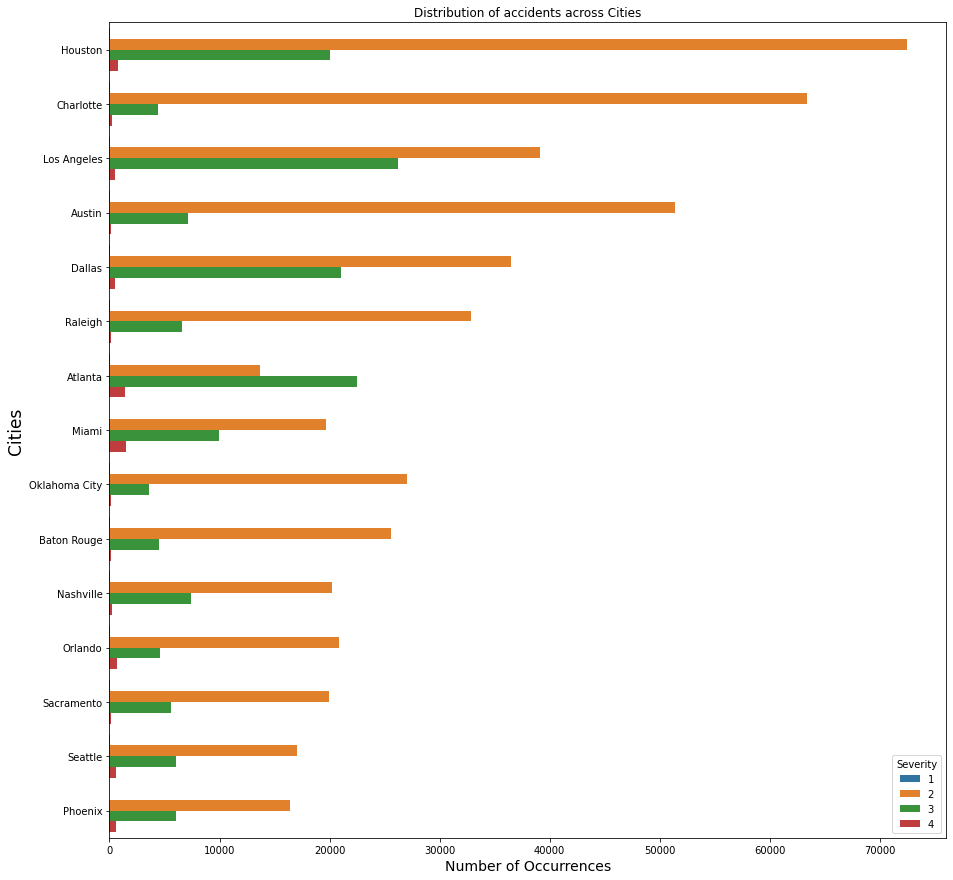

In [ ]:
plt.figure(figsize=(15,15))
sns.countplot(y="City", hue="Severity", data=us_accident_data,order = us_accident_data.City.value_counts().index[:15])
plt.title('Distribution of accidents across Cities')
plt.xlabel('Number of Occurrences', fontsize=14)
plt.ylabel('Cities', fontsize=17)
plt.show()

#### Analyzing _State_

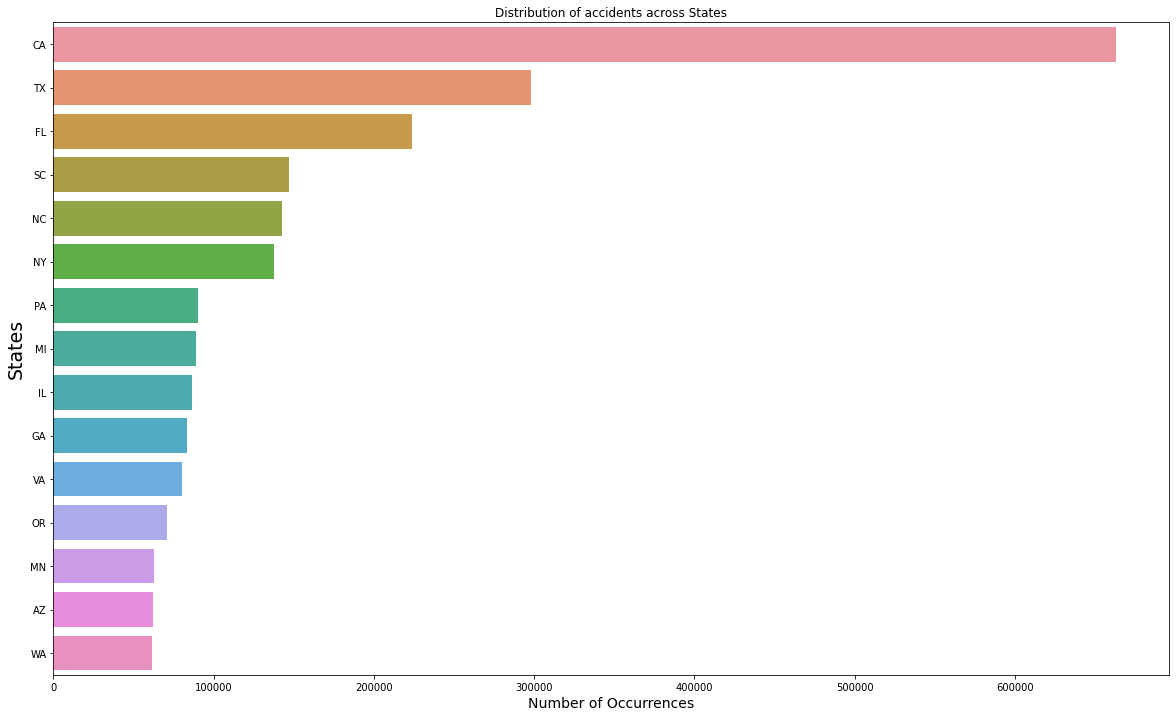

In [ ]:
plt.figure(figsize=(20,12))
sns.countplot(y='State', data = us_accident_data, order = us_accident_data.State.value_counts().index[:15])
plt.title('Distribution of accidents across States')
plt.xlabel('Number of Occurrences', fontsize=14)
plt.ylabel('States', fontsize=19)
plt.show()

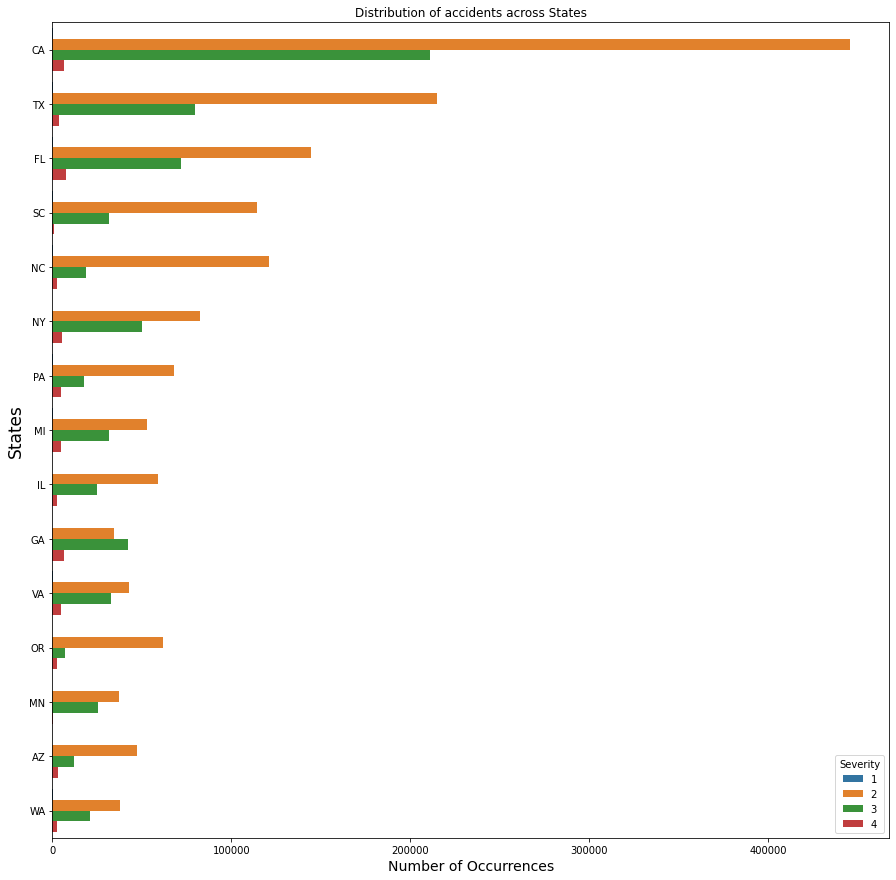

In [ ]:
plt.figure(figsize=(15,15))
sns.countplot(y="State", hue="Severity", data=us_accident_data,order = us_accident_data.State.value_counts().index[:15])
plt.title('Distribution of accidents across States')
plt.xlabel('Number of Occurrences', fontsize=14)
plt.ylabel('States', fontsize=17)
plt.show()


#### Analyzing _County_

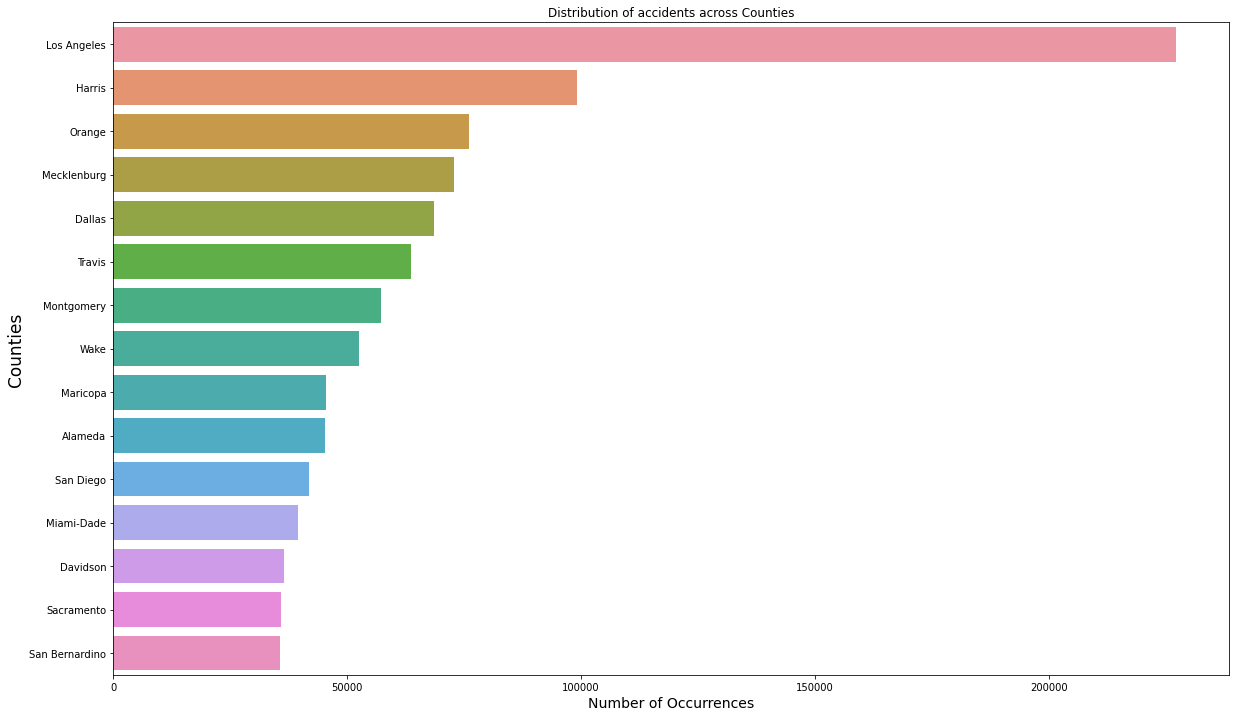

In [ ]:
#CON LAT Y LNG PODRIAMOS OBTENER ESTA INFORMACION PERO LO DEJAMOS DESGLOSADO, MISMO CRITERIO QUE CON STATES
plt.figure(figsize=(20,12))
sns.countplot(y='County', data = us_accident_data, order = us_accident_data.County.value_counts().index[:15])
plt.title('Distribution of accidents across Counties')
plt.xlabel('Number of Occurrences', fontsize=14)
plt.ylabel('Counties', fontsize=17)
plt.show()


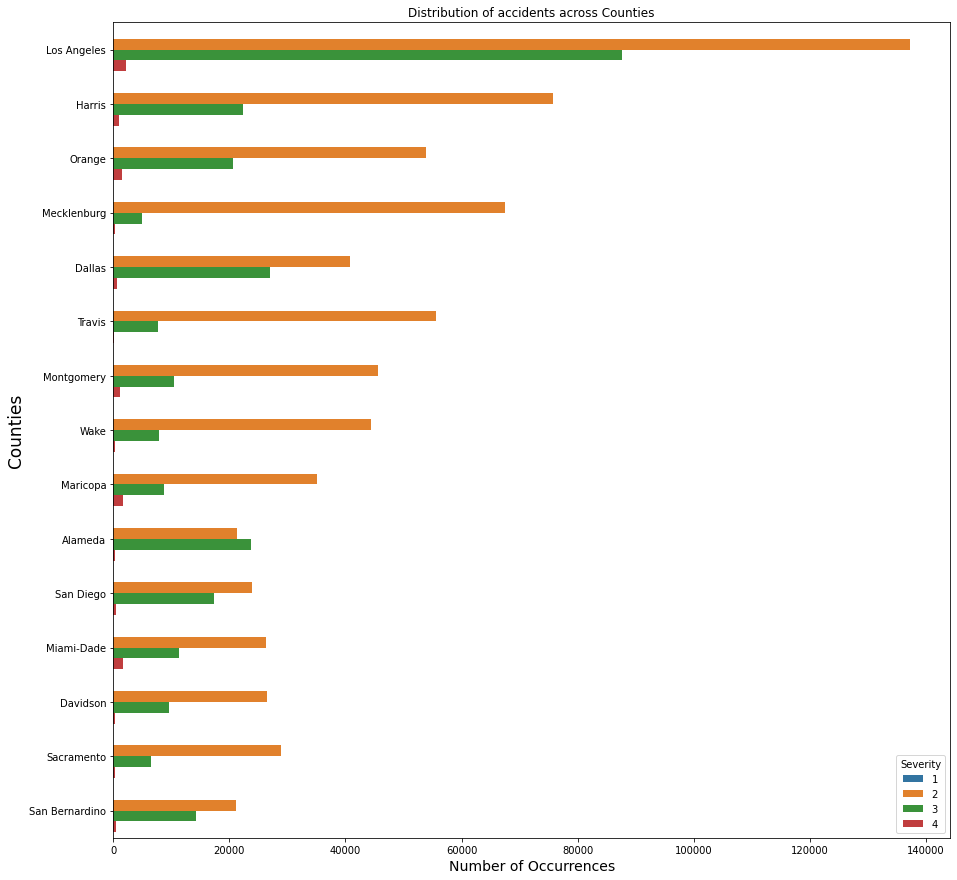

In [ ]:
plt.figure(figsize=(15,15))
sns.countplot(y="County", hue="Severity", data=us_accident_data,order = us_accident_data.County.value_counts().index[:15])
plt.title('Distribution of accidents across Counties')
plt.xlabel('Number of Occurrences', fontsize=14)
plt.ylabel('Counties', fontsize=17)
plt.show()

#### Pearson Correlation

In [ ]:
correlation = us_accident_data[['TMC','Severity','Start_Lat','Start_Lng','Distance(mi)','Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)']].corr(method='pearson')
correlation.style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)
#Las variables con mayor correlación con severity son tmc, y distance, en cuanto a correlación inversa, Temperature y Wind_chill

,TMC,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
TMC,1.0,0.18,-0.0055,-0.022,0.041,0.0045,0.039,0.0061,-0.027,0.0021,-0.00023,0.009
Severity,0.18,1.0,0.047,0.055,0.15,-0.029,-0.08,0.023,0.018,-0.0061,0.03,0.017
Start_Lat,-0.0055,0.047,1.0,-0.014,0.069,-0.42,-0.5,0.049,-0.08,-0.053,0.052,0.0052
Start_Lng,-0.022,0.055,-0.014,1.0,0.04,-0.068,-0.19,0.19,0.14,-0.048,0.07,0.045
Distance(mi),0.041,0.15,0.069,0.04,1.0,-0.045,-0.052,0.018,-0.033,-0.012,0.016,0.0011
Temperature(F),0.0045,-0.029,-0.42,-0.068,-0.045,1.0,0.99,-0.33,-0.072,0.18,-0.03,-0.013
Wind_Chill(F),0.039,-0.08,-0.5,-0.19,-0.052,0.99,1.0,-0.31,-0.24,0.19,-0.19,-0.037
Humidity(%),0.0061,0.023,0.049,0.19,0.018,-0.33,-0.31,1.0,0.091,-0.38,-0.13,0.061
Pressure(in),-0.027,0.018,-0.08,0.14,-0.033,-0.072,-0.24,0.091,1.0,-0.02,0.018,0.04
Visibility(mi),0.0021,-0.0061,-0.053,-0.048,-0.012,0.18,0.19,-0.38,-0.02,1.0,0.008,-0.083


#### Analyzing _Zipcode_
As we can see, part of the dataset is with the complete cod-pod, while others with the reduced one, since most have the reduced one, we will use this one.

Text(0, 0.5, 'Zipcodes')

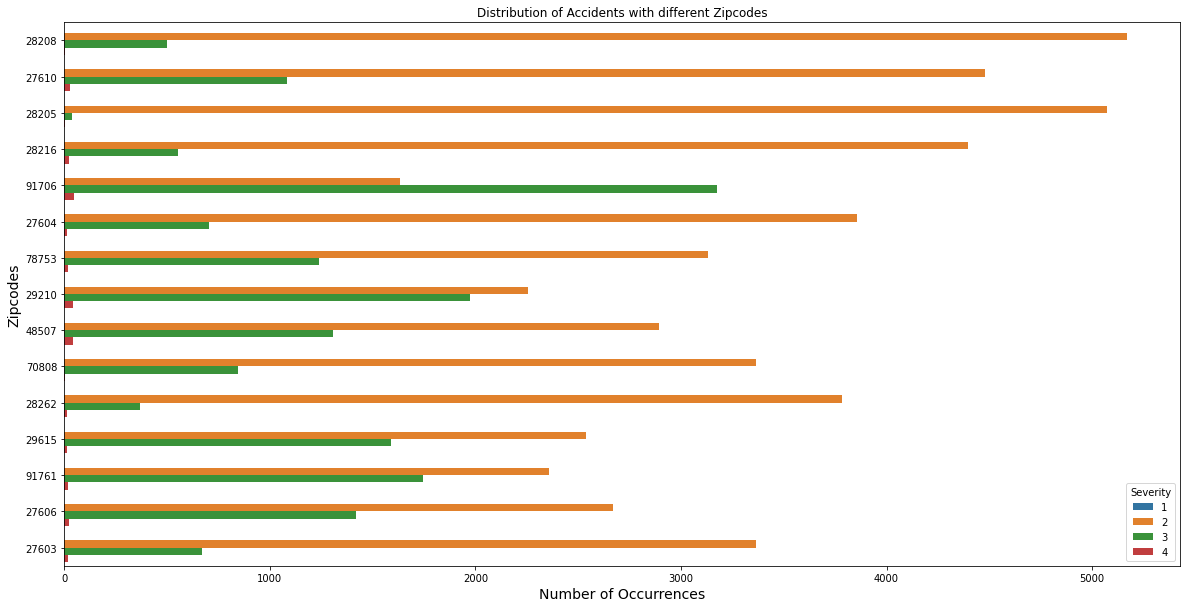

In [ ]:
us_accident_data = us_accident_data.assign(Zipcode=us_accident_data.Zipcode.str.split('-').str[0])
plt.figure(figsize=(20,10))
sns.countplot(y='Zipcode',hue='Severity', data = us_accident_data, order = us_accident_data.Zipcode.value_counts().index[:15])
plt.title('Distribution of Accidents with different Zipcodes')
plt.xlabel('Number of Occurrences', fontsize=14)
plt.ylabel('Zipcodes', fontsize=14)

In [ ]:
zipcode = us_accident_data.Zipcode.value_counts().head(10).reset_index()
zipcode.columns=['Zipcode','Amount']
zipcode

,Zipcode,Amount
0,28208,5677
1,27610,5592
2,28205,5117
3,28216,4975
4,91706,4854
5,27604,4577
6,78753,4388
7,29210,4276
8,48507,4246
9,70808,4217


#### Analyzing _Timezone_

It will be very useful to later convert _start_time_ to UTC + 0

In [ ]:
timezone = us_accident_data.Timezone.value_counts().head(10).reset_index()
timezone.columns=['Timezone','Amount']
timezone

,Timezone,Amount
0,US/Eastern,1277187
1,US/Pacific,805117
2,US/Central,727147
3,US/Mountain,161721


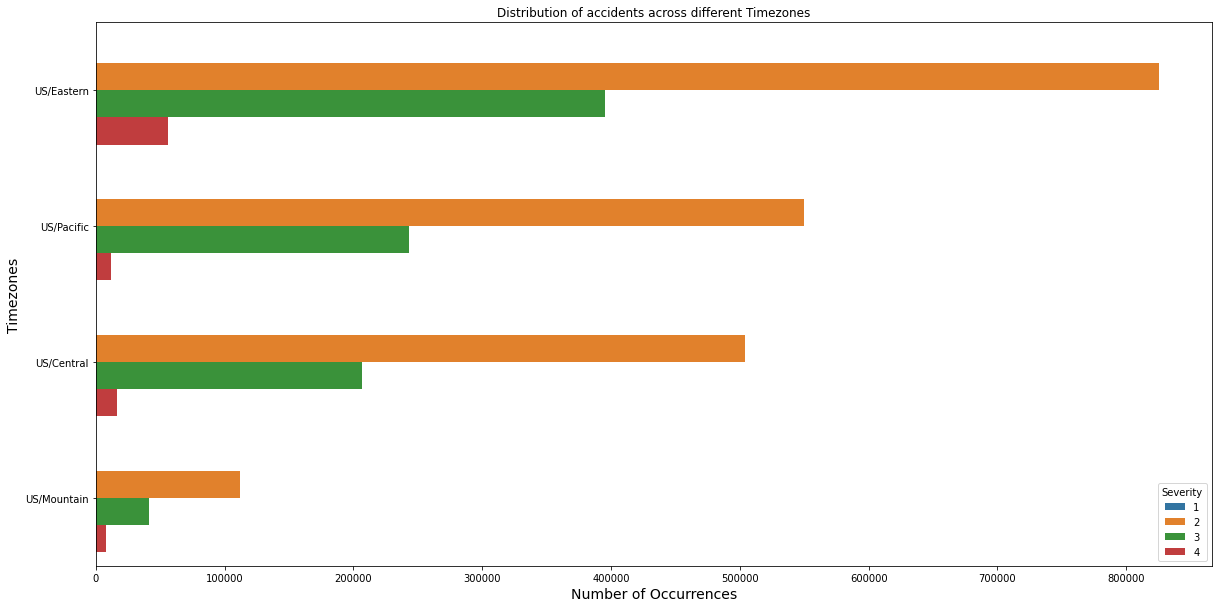

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(y='Timezone',hue='Severity', data = us_accident_data, order = us_accident_data.Timezone.value_counts().index)
plt.title('Distribution of accidents across different Timezones')
plt.xlabel('Number of Occurrences', fontsize=14)
plt.ylabel('Timezones', fontsize=14)
plt.show()

#### Analyzing _wind_speed(mph)_

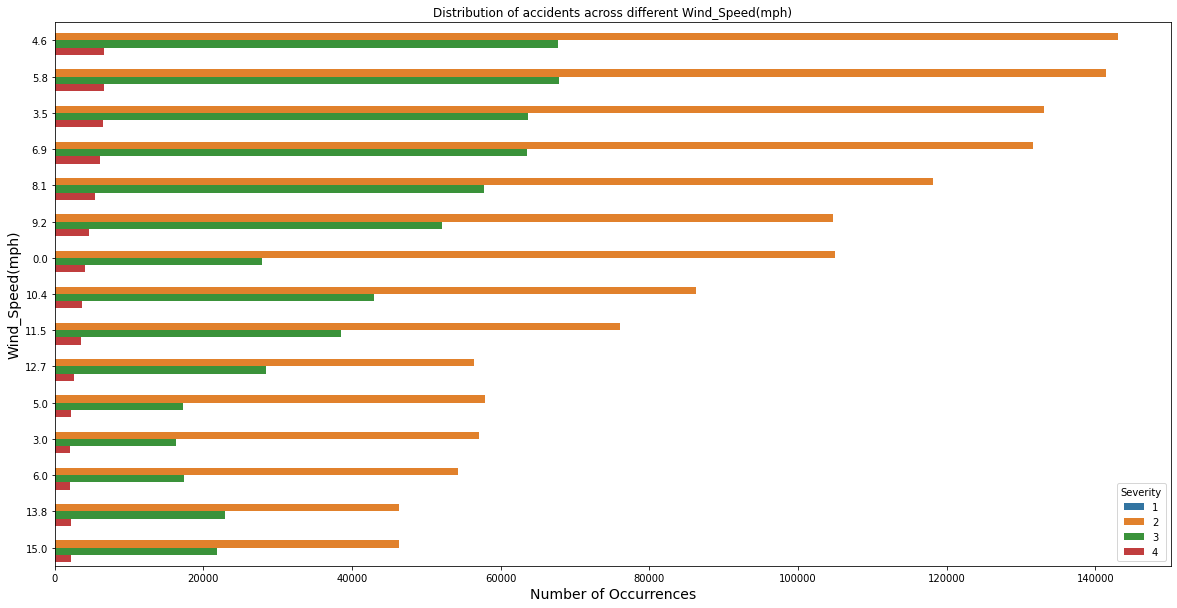

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(y='Wind_Speed(mph)',hue='Severity', data = us_accident_data, order = us_accident_data['Wind_Speed(mph)'].value_counts().index[:15])
plt.title('Distribution of accidents across different Wind_Speed(mph)')
plt.xlabel('Number of Occurrences', fontsize=14)
plt.ylabel('Wind_Speed(mph)', fontsize=14)
plt.show()

#### Analyzing _civil_ _twilight_

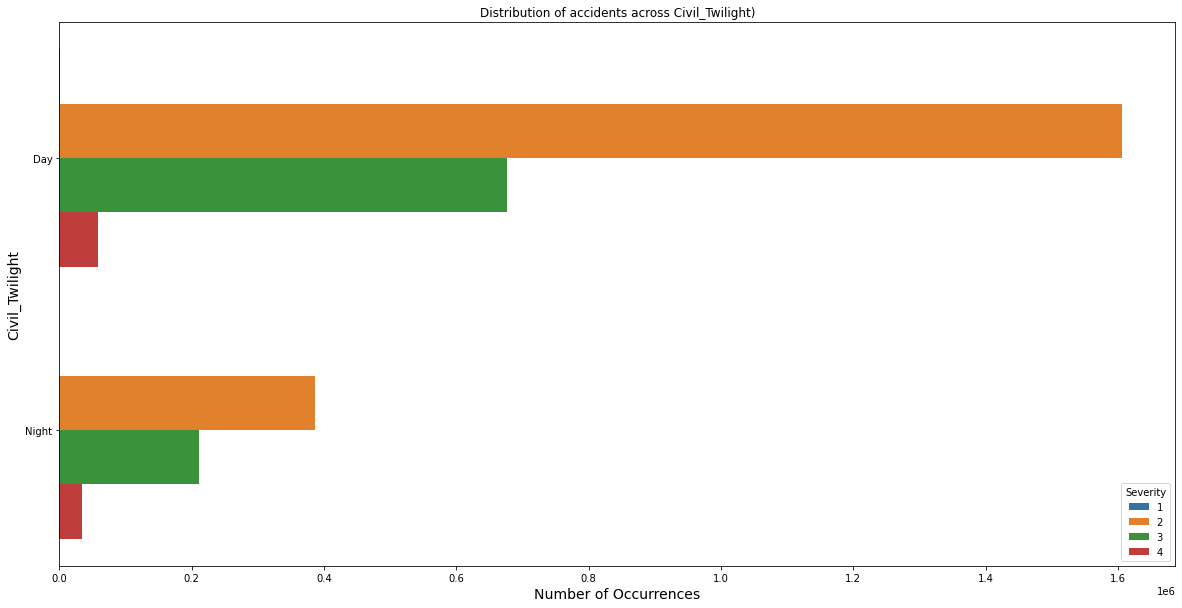

In [4]:
plt.figure(figsize=(20,10))
sns.countplot(y='Civil_Twilight',hue='Severity', data = us_accident_data, order = us_accident_data['Civil_Twilight'].value_counts().index[:15])
plt.title('Distribution of accidents across Civil_Twilight)')
plt.xlabel('Number of Occurrences', fontsize=14)
plt.ylabel('Civil_Twilight', fontsize=14)
plt.show()